In [1]:
# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax, mean

fs = 1000
dir = os.path.join(os.path.realpath(''),'Data/20200520_18h35m_HongNhung_run.txt')
emg_raw = []

with open(dir) as f:
    lines = f.readlines()
for l in lines:
    emg_raw.append(float(l.replace("\n","")))

time = linspace(0, len(emg_raw) / fs, len(emg_raw))

low_cutoff = 20 # Hz
high_cutoff = 450 # Hz


In [2]:
emg_detrend = emg_raw - mean(emg_raw)
burst_begin, burst_end = bsnb.detect_emg_activations(emg_detrend, fs, smooth_level=20, threshold_level=10, 
                                                     time_units=True, plot_result=True)[:2]

In [3]:
print('EMG Onset Points: ',burst_begin)
print('EMG Offset Points: ', burst_end)
print('Number of Muscular Activations: ', len(burst_begin))

# Bursts Duration
bursts_time = burst_end - burst_begin

# Parameter extraction
max_time = max(bursts_time)
min_time = min(bursts_time)
avg_time = average(bursts_time)
std_time = std(bursts_time)

duration_extract = {'Maximum Activation Time':max_time, 
                     'Minimum Activation Time':min_time, 
                     'Average Activation Time':avg_time, 
                     'Standard deviation Time':std_time}
for x in duration_extract:
    print(x, ': ',"{:.3f}".format(duration_extract[x]),'s')



EMG Onset Points:  [ 0.661011    1.27702125  2.77104611  3.57505949  4.36707266  5.10208489
  5.94209887  6.71211168  7.41212333  8.26613754  9.07115093  9.88716451
 10.74217874 11.5691925  12.44920714 13.35722225 14.27123746 15.16125227
 16.08126758 16.99328275 17.89829781 18.77031232 19.67732741 20.53934175
 21.46535716 22.26237042 23.30438776 24.16340205 25.04041665 25.9934325
 26.94544834 27.87946388 28.81147939 29.82549626 30.77151201 31.71952778
 32.7125443  33.65956006 34.61357593 35.47859033 36.45560658 37.42262267
 38.31563753 39.23265279 40.16966838 41.12468427 42.03769946 42.90571391
 43.8367294  44.76474484 45.69476031 46.62477579 47.43778931 48.34380439
 49.20281868 50.02983244 50.90184695 51.77686151 52.55887452 53.43588912
 54.33190403 55.19191833 56.06893293 56.97294797 57.85596266 58.77597797]
EMG Offset Points:  [ 1.24202067  2.67604453  3.39705652  4.18506964  4.99908318  5.72809531
  6.52010849  7.30912162  8.19813641  8.90414816  9.70916155 10.49117456
 11.32518844

In [4]:
print(len(emg_raw))

60100


(56061, 642, 1)


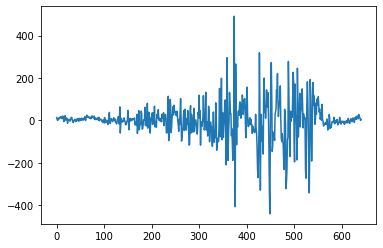

In [5]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

emg_timeseries = pd.DataFrame({ "EMG_Amplitude": pd.Series(emg_detrend)}) #turn into pandas Dataframe

onset_points = [int(i*1000) for i in burst_begin]
offset_points = [int(i*1000) for i in burst_end]
#including 66 EMG bursts
emg_sequences = []
time_steps = 642 
#average length of sequences = 642
    
for i in range(3397, len(emg_timeseries) - time_steps):
        emg_sequences.append(emg_timeseries.values[i : (i + time_steps)])
        
emg_train = np.stack(emg_sequences)
print(emg_train.shape)  
plt.plot(emg_train[1])

In [6]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


model = Sequential()
model.add(LSTM(128, input_shape=(emg_train.shape[1], emg_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(emg_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(emg_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 642, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 642, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 642, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 642, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(emg_train, emg_train, epochs=50, batch_size=256, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)
